# STRF Estimation.  

**This notebooks tests python implementation of strf direct fit _strfpy_**




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import windows

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
# from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


Set up the path

In [3]:
# Change this if you move around files

path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(dataDir, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [4]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(dataDir, cellDirName, 'conspecific')


In [5]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [6]:
# Preprocess the stimuli and the response to get features and store them in srData
# Sound preprocessing is STFT - otherwise known as the spectrogram
#  Response preprocessing is generating a PSTH from raw spikes - but both the raw spikes and the PSTH are preserved.

preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)

preprocOptions = {} # we'll leave this empty and use default options
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)


In [7]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

### Starting srtflab calculations. 
To start fresh start (but without recalculating spectrograms) you need to start here and also delete the df_temp_resp and df_temp_stim created in the temp directory

In [8]:
# Initialize the linear time invariant model. Here we choose 75 delay points 
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']
strfLength = 75
strfDelays = np.arange(strfLength)
modelParams = strfSetup.linInit(nStimChannels, strfDelays)

# Convert srData into a format that strflab understands
allstim, allresp, groupIndex = strfSetup.srdata2strflab(srData, useRaw = False)
globDat = strfSetup.strfData(allstim, allresp, groupIndex)

# Create default optimization options structure
params, optOptions = trnDirectFit.trnDirectFit()
optOptions['display'] = 1


In [9]:
# Run direct fit optimization on all of the data
datIdx = np.arange(len(allresp)) # the indexes of training data (all of it)
modelParamsTrained, options = strfSetup.strfOpt(modelParams, datIdx, optOptions, globDat)

Now calculating stim autocorrelation
Done auto-correlation calculation
The autocorrelation took 74.162389 seconds.
Now doing cross-correlation calculation.
Done calculation of cross-correlation.
Now calculating JN cross-correlation.
Done calculation of JN cross-correlation.
Calculating strfs for each tol value.
Done df_fft_AutoCrossCorr.
Calculating STRF for each tol value...
Now calculating STRF for tol_value: 0.1
Done calculation of STRF for tol_value: 0.1

Now calculating STRF for tol_value: 0.05
Done calculation of STRF for tol_value: 0.05

Now calculating STRF for tol_value: 0.01
Done calculation of STRF for tol_value: 0.01

Now calculating STRF for tol_value: 0.005
Done calculation of STRF for tol_value: 0.005

Now calculating STRF for tol_value: 0.001
Done calculation of STRF for tol_value: 0.001

Now calculating STRF for tol_value: 0.0001
Done calculation of STRF for tol_value: 0.0001

Now calculating STRF for tol_value: 5e-05
Done calculation of STRF for tol_value: 5e-05

Now 

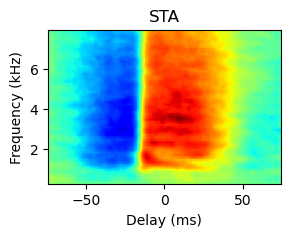

In [10]:
# display the stimulus response cross-correlation.

plt.figure(figsize=(3,2), dpi=100)

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']

crossCorr = np.load(os.path.join(options['outputDir'], 'StimResp_crosscorr.npy'))

maxabs = np.max(np.abs(crossCorr))

plt.imshow(crossCorr, origin='lower', cmap = 'jet', aspect='auto',
           extent=[-strfDelays[-1], strfDelays[-1], strfFrequencies[0]*1e-3, strfFrequencies[-1]*1e-3],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (kHz)')
plt.title('STA')
plt.savefig(os.path.join(figDir, 'sta.eps'))

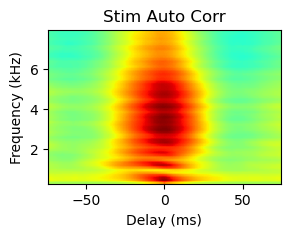

In [11]:
# display the stimulus auto-correlation of band0 with all others (the first row in the upper diagonal matrix)
plt.figure(figsize=(3,2), dpi=100)

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']
nbands = modelParams['nIn']

autoCorr = np.load(os.path.join(options['outputDir'], 'Stim_autocorr.npy'))

maxabs = np.max(np.abs(autoCorr[0:nbands,:]))


plt.imshow(autoCorr[0:nbands,:], origin='lower', cmap = 'jet', aspect='auto',
           extent=[-strfDelays[-1], strfDelays[-1], strfFrequencies[0]*1e-3, strfFrequencies[-1]*1e-3],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (kHz)')
plt.title('Stim Auto Corr')
plt.savefig(os.path.join(figDir, 'stimCorr.eps'))

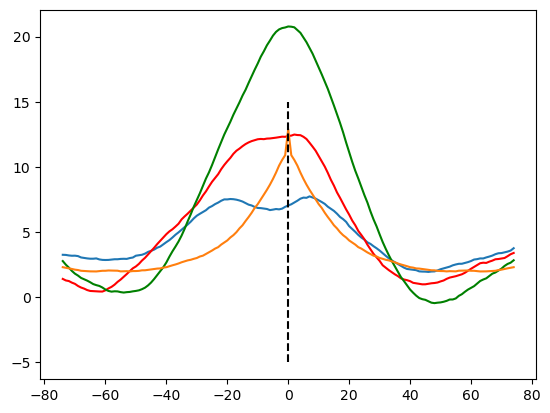

In [12]:
# The stimulus auto-correlations looks ok.

# display the stimulus auto-correlation
plt.figure()

# Looks at first ds to examine frequencies


plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[5,:])
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[10,:], 'r')
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[20,:], 'g')
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[0,:])

plt.plot([0, 0], [-5, 15], 'k--')

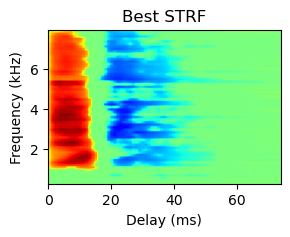

In [13]:
# display the best STRF
plt.figure(figsize=(3,2), dpi=100)

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']

mySTRF = np.real(modelParamsTrained['w1'])
maxabs = np.max(np.abs(mySTRF))

plt.imshow( mySTRF, origin='lower', cmap = 'jet', aspect='auto',
           extent=[strfDelays[0], strfDelays[-1], strfFrequencies[0]*1e-3, strfFrequencies[-1]*1e-3],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (kHz)')
plt.title('Best STRF')
plt.savefig(os.path.join(figDir, 'strf.eps'))

compute prediction for each stim/response pair and concatenate them, <br>
also split the real PSTHs in half and concatenate them across pairs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


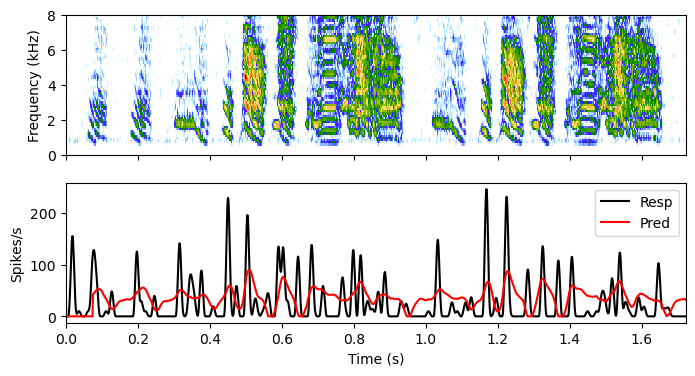

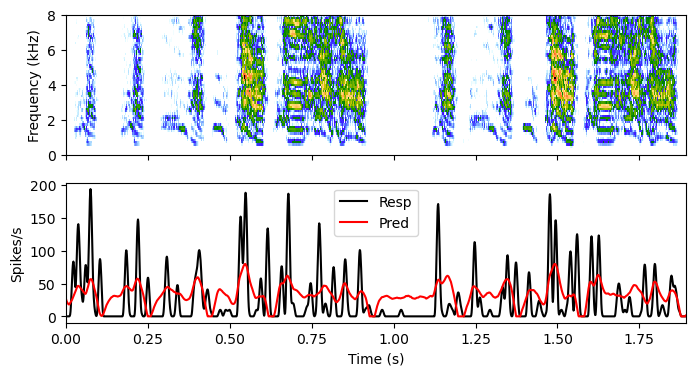

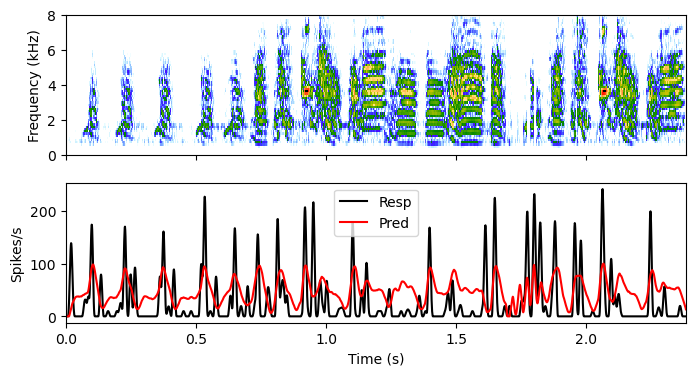

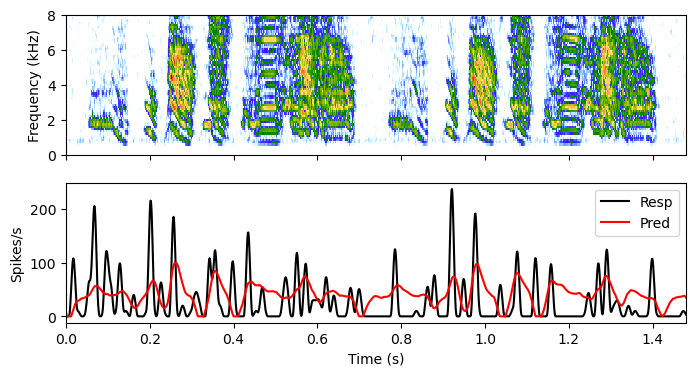

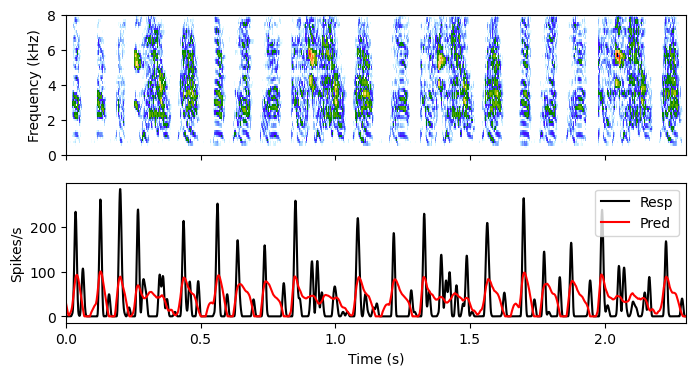

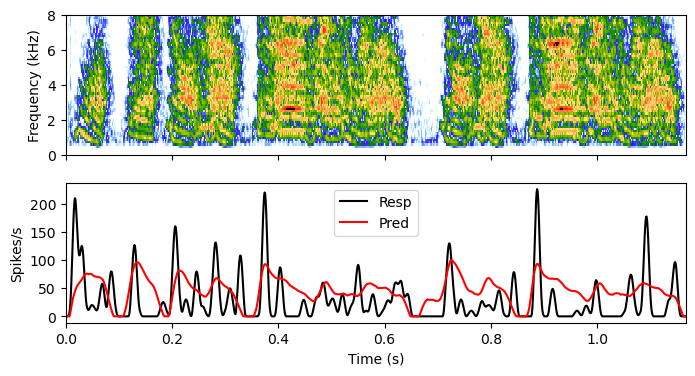

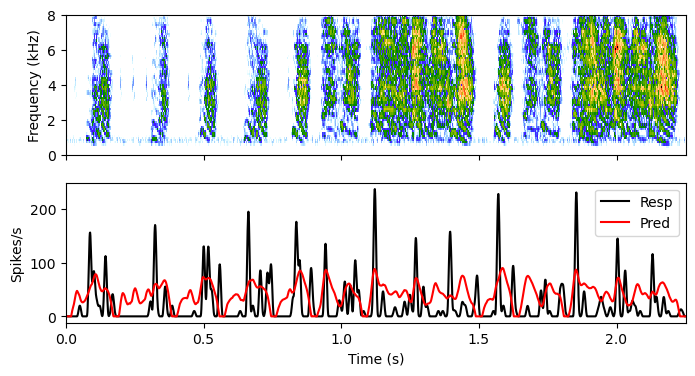

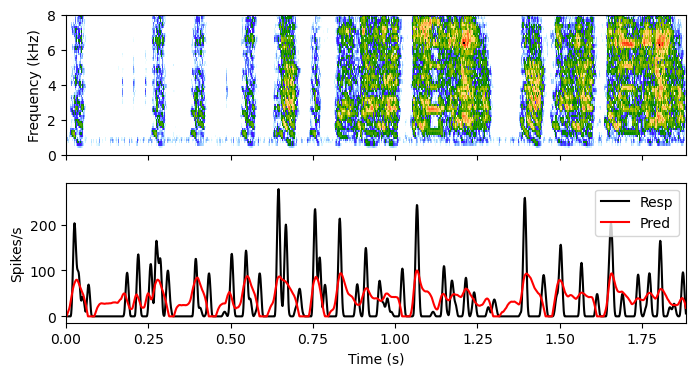

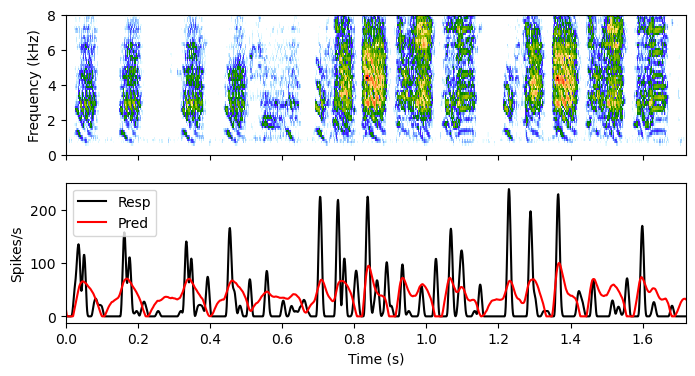

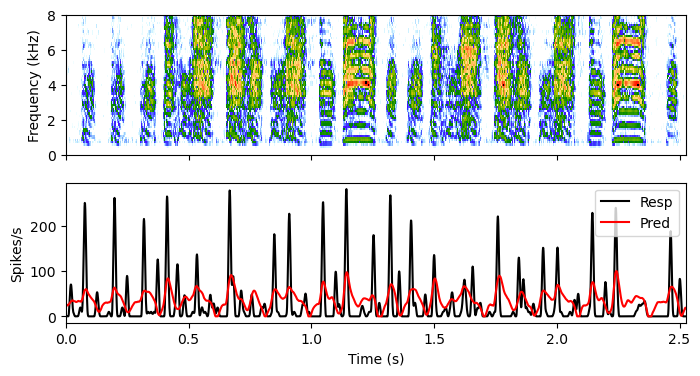

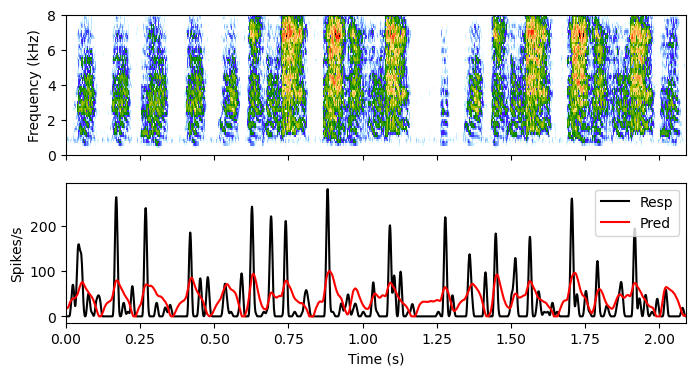

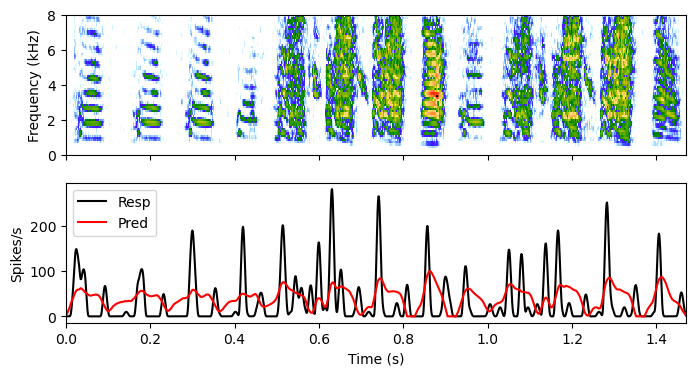

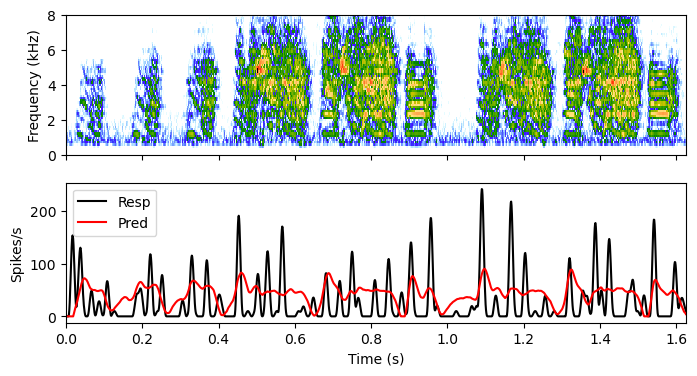

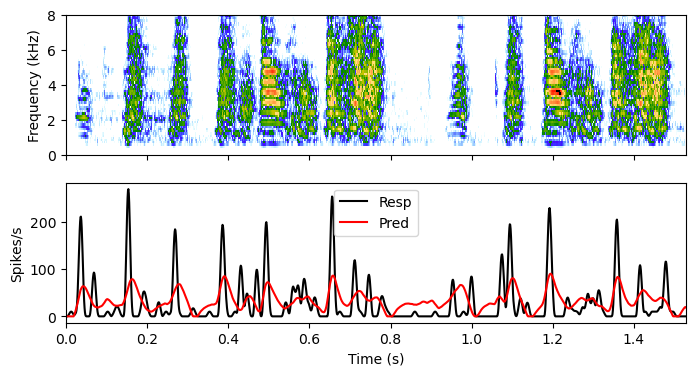

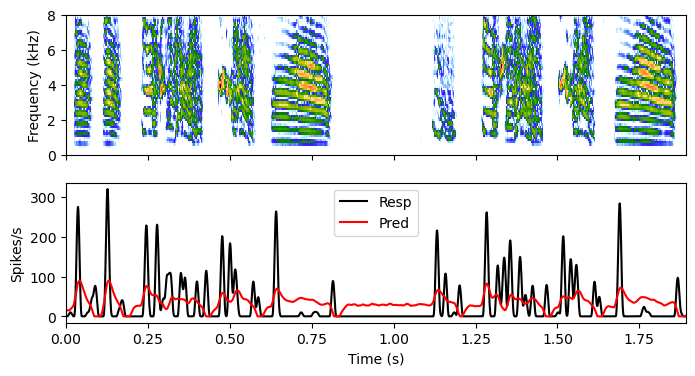

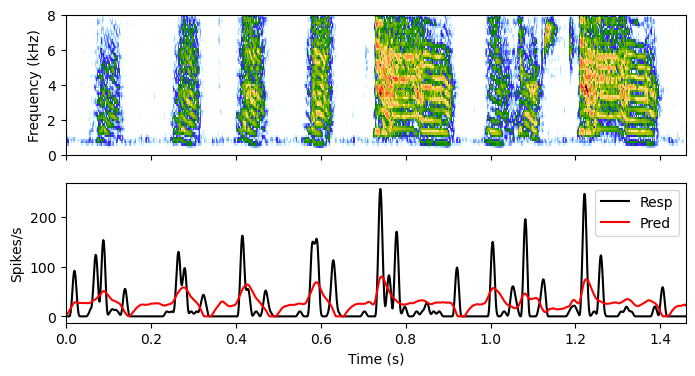

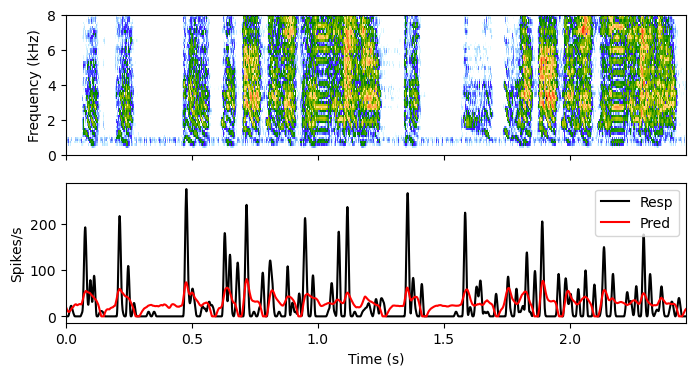

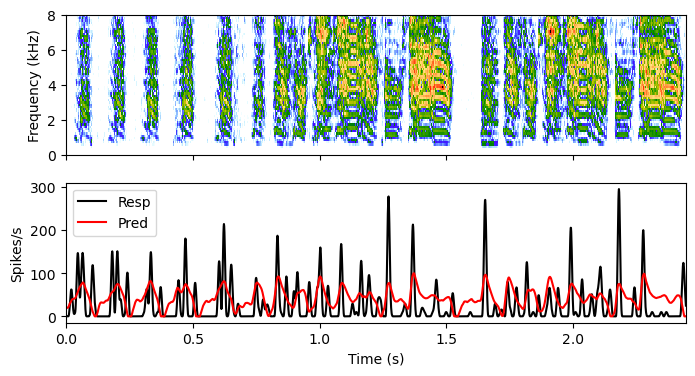

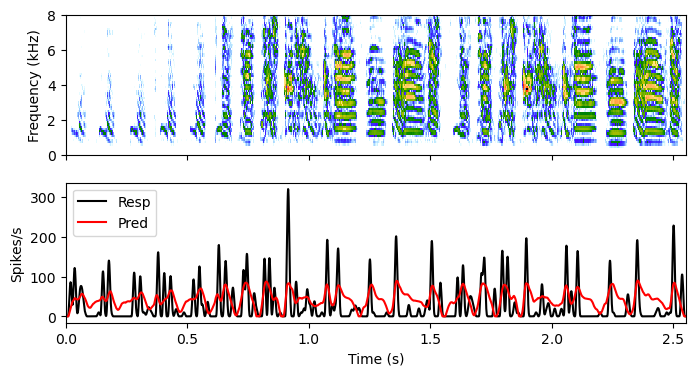

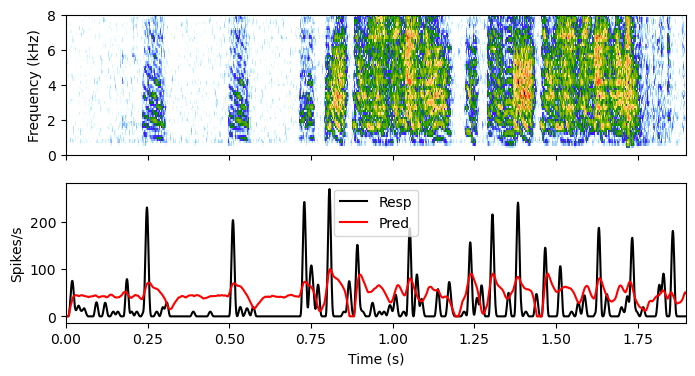

In [14]:
# Color map for spectrograms
spec_colormap()   # defined in sound.py
cmap = plt.get_cmap('SpectroColorMap')
DBNOISE = 50  # Color Threshold for spectrogram

pairCount = len(srData['datasets'])
# Making variables for the concatenated predictions
concatPredResp = np.array([])
concatResp = np.array([])

# We are calculating these for a coherence estimation but this is not happening yet.
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])
pairCountTrials = np.zeros(pairCount)


for k in range(pairCount):
    # get stim and response
    ds = srData['datasets'][k]
    tfrep = ds['stim']['tfrep']
    strfFrequencies = tfrep['f']


    strflabIndx = np.where(groupIndex == k)[0]
    stim = allstim[strflabIndx, :]
    resp = allresp[strflabIndx]

    # Smooth the response with a 31 ms window
    wHann = windows.hann(21, sym=True)
    respSmoothed = np.convolve(resp, wHann, mode='same')

    # compute prediction
    modelParamsTemp, predResp = strfSetup.strfFwd(modelParamsTrained, strflabIndx, globDat)
    del modelParamsTemp

    # fix any NaNs in response
    predResp = predResp[0]
    predResp[np.isnan(predResp)] = 0

    # rectify response
    predResp[predResp < 0] = 0

    # scale predicted response
    predResp = (predResp / max(predResp)) * max(resp)

    # concatenate PSTH halves and predicted PSTH for this trial
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeIndicies'], resp.shape[0])
    numTrials = len(ds['resp']['rawSpikeTimes'])

    concatPredResp = np.concatenate((concatPredResp, predResp))
    concatResp = np.concatenate((concatResp, respSmoothed))
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    pairCountTrials[k] = numTrials

    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))
    
    # The spectrogram
    soundSpect = np.copy(tfrep['spec'])
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # plt.xlabel('Time (s)')

    
    # plot response and prediction
    fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
    ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
    ax2.plot(tfrep['t'], predResp*fac, 'r', label='Pred')
    ax2.legend()
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Spikes/s')

    if k  == 2 :
        plt.savefig(os.path.join(figDir, 'stimRespSTRFPred%d.eps' % (k)))
        



In [15]:
pairCountTrials

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10.])

In [16]:

# Pearson r betwen prediction and response
r = np.corrcoef(concatPredResp, concatResp)[0,1]
# Pearson r betwwen two half of psth to get estimate of Explainable Variance (EV)
r12 = np.corrcoef(np.convolve(concatPsthHalf1, wHann, mode='same'), np.convolve(concatPsthHalf2, wHann, mode='same'))[0,1]

# The following code is only exactkt correct in pairCountTrials are equal for all stim-resp pairs but good aprox otherwise
SNRAll = 2*r12/(1-r12)
R2Ceil = SNRAll/(1+SNRAll)   # This is the ceiling value of R2 for predicting the smoothed PSTH
print('r= %.3f, R2 = %.3f R2Ceil = %.3f R2Norm = %.3f' % (r, r*r, R2Ceil, r*r/R2Ceil))

r= 0.425, R2 = 0.181 R2Ceil = 0.972 R2Norm = 0.186


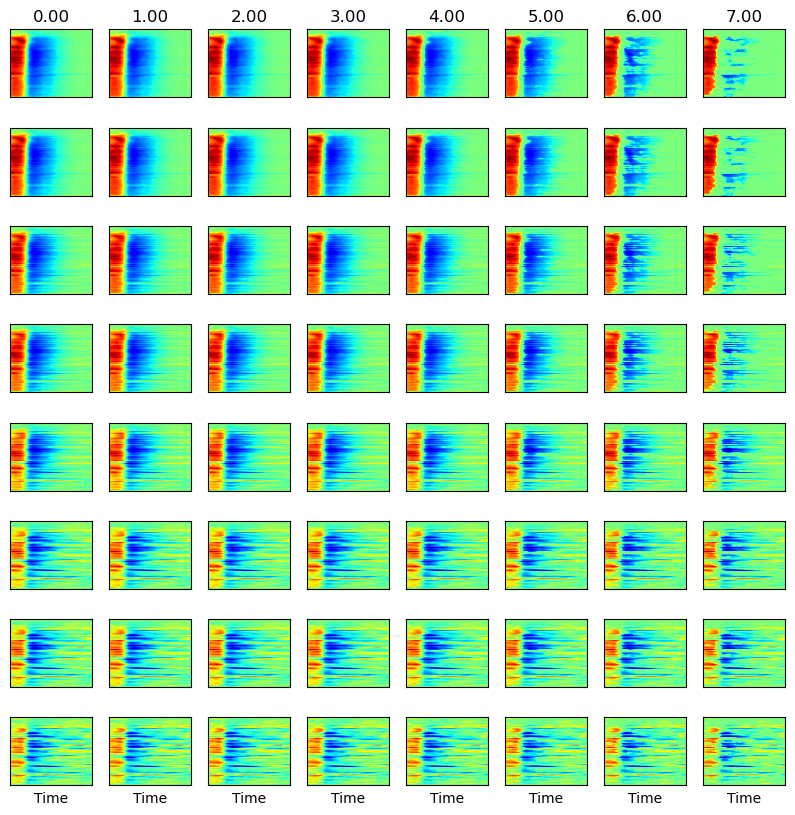

In [17]:
%matplotlib inline
# Create a list of file names for each tolerance
strfFiles = [os.path.join(options['outputDir'], f'strfResult_Tol{k}.npz') for k in range(1, len(options['tolerances']) + 1)]

# Choose the temporal section of the STRF that is used in the convolution
halfIndx = int(np.ceil(np.max(np.abs(modelParams['delays']))) + 1)  # This is the point corresponding to zero
startIndx = int(halfIndx + round(np.min(modelParams['delays'])))
endIndx = int(halfIndx + round(np.max(modelParams['delays'])))
# strfRng = np.arange(startIndx, endIndx)

fig, axs = plt.subplots(len(options['tolerances']), len(options['sparsenesses']), figsize=(10, 10))
maxall = np.zeros((len(options['tolerances']), len(options['sparsenesses'])))

for k in range(len(options['tolerances'])):

    svars = np.load(strfFiles[k], allow_pickle=True)
    strfsJN = svars['STRFJN_Cell']
    strfsJN_std = svars['STRFJNstd_Cell']
    strfMean = svars['STRF_Cell']
    strfStdMean = np.mean(strfsJN_std, axis=2)
    
    # Clear the variable to free up memory
    del svars
    
    for q in range(len(options['sparsenesses'])):
        ax = axs[k, q]
        
        smoothedMeanStrf = trnDirectFit.df_fast_filter_filter(strfMean, strfStdMean, options['sparsenesses'][q])
        # smoothedMeanStrf = strfMean

        im = ax.imshow(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])
                       , cmap='jet'
                       , vmin=-np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                       , vmax=np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                      )
        maxall[k, q] = np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
        
        # fig.colorbar(im, ax=ax)
        # im.set_clim(-maxall[k, q], maxall[k, q])
        ax.set_xticks([])
        ax.set_yticks([])
        if k == 0:
            ax.set_title('%.2f' % options['sparsenesses'][q])
        if k == len(options['tolerances']) - 1:
            ax.set_xlabel('Time')

        

plt.show()
